# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

In [94]:
def create_matrix(diag_broadcast, n):
    m = len(diag_broadcast)
    # check the num of diagonals in matrix
    assert m==3 or m==5
    if (m==3):
    #     get tridiagonal matrix
        diagonals = [[diag_broadcast[0]]*(n-1), [diag_broadcast[1]]*n, [diag_broadcast[2]]*(n-1)]
        A = diags(diagonals, [-1, 0, 1])
    else:
    #     get pentidiagonal matrix
        diagonals = [[diag_broadcast[0]]*(n-2), [diag_broadcast[1]]*(n-1), [diag_broadcast[2]]*n, [diag_broadcast[3]]*(n-1), [diag_broadcast[4]]*(n-2)]
        A = diags(diagonals, [-2, -1, 0, 1, 2])
    return A

In [95]:
# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
from scipy.sparse import diags 
import numpy as np

def band_lu(diag_broadcast, n):
    bandwidth  = len(diag_broadcast)
    L = np.zeros(((bandwidth-1) // 2, n-1))
    U = np.zeros((n, (bandwidth+1) // 2))
    
    # keep matrix in sparse format, or use function create_matrix().toarray() for dense format.
    A = diags([0]*n)
    A += create_matrix(diag_broadcast, n)
    for k in range(n):
        if k <= n-1:
            for i in range(min(L.shape[0], n-k-1)):
                assert A[k,k] != 0, 'Use pivoting algorithm for this matrix!'
                L[i, k] = A[k+i+1, k] / A[k, k]
                for j in range(k+1, n):
                    A[k+i+1, j] -= L[i, k] * A[k, j]
                    
        for j in range(min(U.shape[1], n-k)):
            U[k, j] = A[k, k+j]
    return L, U

In [96]:
diag_broadcast = [1, -2, 3]
n=5
L, U = band_lu(diag_broadcast, n)
print(U.shape, L.shape)

(5, 2) (1, 4)


D:\conda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [97]:
from scipy.linalg import lu
import time
from tqdm import tqdm

dim = [10,50,100,200, 300]

time_lib = []
time_impl = []

diag_broadcast = [1, -2, 3]

for i in tqdm(range(len(dim))):
    start_time = time.time()
    A = create_matrix(diag_broadcast, dim[i]).toarray()
    L, U = lu(A, permute_l=True)
    time_lib.append(time.time()-start_time)
    
    start_time = time.time()
    L, U = band_lu(diag_broadcast = [1, -2, 3], n=dim[i])
    time_impl.append(time.time()-start_time)  

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


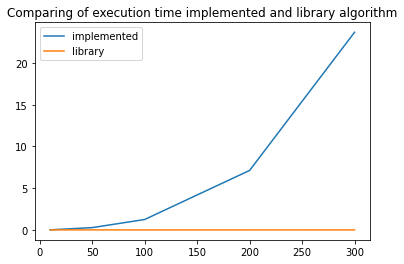

In [98]:
from matplotlib import pyplot as plt

plt.title('Comparing of execution time implemented and library algorithm')
plt.plot(dim, time_impl, label = 'implemented')
plt.plot(dim, time_lib, label = 'library')
plt.legend()
plt.show()

As we could see library algorithm is much more better, than implemented one, even if we works with sparse matrices.

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.

$\circ$ Without pivoting 

$\begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}  \overset{R_{2}-=\frac{1}{\epsilon}R_{1}}{=} \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-\frac{1}{\epsilon} & 1\\
0 & 1 & 1
\end{pmatrix} = \overset{R_{3}-=\frac{\epsilon}{\epsilon-1}R_{2}}{=} \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\epsilon - 1}{\epsilon} & 1\\
0 & 0 & -\frac{1}{\epsilon-1}
\end{pmatrix}$

$U = \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\epsilon - 1}{\epsilon} & 1\\
0 & 0 & -\frac{1}{\epsilon-1}
\end{pmatrix}$ 

$L = \begin{pmatrix}
1 & 0 & 0\\
\frac{1}{\epsilon} & 1 & 0\\
0 & \frac{\epsilon}{\epsilon-1} & 1
\end{pmatrix}$


$\circ$ With pivoting 

$\begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}  \overset{R_{2}\leftrightarrow R_{1}}{=} \begin{pmatrix}
1 & 1 & 1\\
\varepsilon & 1 & 0\\
0 & 1 & 1
\end{pmatrix} \overset{R_{2}-=\epsilon R_{1}}{=} \begin{pmatrix}
1& 1 & 1\\
0 & 1 -\epsilon  & -\epsilon\\
0 & 1 & 1
\end{pmatrix}\overset{R_{3}\leftrightarrow R_{2}}{=} \begin{pmatrix}
1& 1 & 1\\
0 & 1 & 1\\
0 & 1 -\epsilon  & -\epsilon
\end{pmatrix}\overset{R_{3}-=(1-\epsilon) R_{2}}{=} \begin{pmatrix}
1& 1 & 1\\
0 & 1 & 1\\
0 & 0 & -1
\end{pmatrix}$

$U = \begin{pmatrix}
1& 1 & 1\\
0 & 1 & 1\\
0 & 0 & -1
\end{pmatrix}$ 

$L = \begin{pmatrix}
1 & 0 & 0\\
\epsilon & 1 & 0\\
0 & 1 - \epsilon & 1
\end{pmatrix}$

$P = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1\\
1 & 0 & 0
\end{pmatrix}$

* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

Answer: Because for $\epsilon\ll 1: \frac{1}{\epsilon}\rightarrow\infty$ and it leads  to arithmetic overflow of computer and  loss in accuracy.


### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.

$\square \ \ \ $ $\begin{equation*}
 \begin{cases}
   A_{11}u_{1}+A_{12}u_{2}=f_{1} |A_{21}A_{11}^{-1} \\
   A_{21}u_{1}+A_{22}u_{2}=f_{2}
 \end{cases}
\end{equation*} \Leftrightarrow $

$\begin{equation*}
 \begin{cases}
   A_{21}u_{1}+A_{21}A_{11}^{-1}A_{12}u_{2}=A_{21}A_{11}^{-1}f_{1} \\
   A_{21}u_{1}+A_{22}u_{2}=f_{2}
 \end{cases}
\end{equation*} \Leftrightarrow $

Subtract from second equation first:

$(A_{22}-A_{21}A_{11}^{-1}A_{12})u_{2}=f_{2}-A_{21}A_{11}^{-1}f_{1}$

$Su_{2}=\hat{f}$

$S=A_{22}-A_{21}A_{11}^{-1}A_{12}$

$\hat{f}=f_{2}-A_{21}A_{11}^{-1}f_{1}$ $\ \ \ \blacksquare$



* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$

where $X$ - nonsingular square matrix.


 $\square $ Use Schur complement property: $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$

$\det A = \det A_{11}\det S_{11}$, where $S_{11}=A_{22}-A_{21}A_{11}^{-1}A_{12}$ is Schur complement of the block $A_{11}$

$ X+AB = \begin{bmatrix} X+AB & A \\ 0 & I \end{bmatrix}=\begin{bmatrix} X & A \\ -B & I \end{bmatrix}\begin{bmatrix} I & 0 \\ B & I \end{bmatrix}$

$\det\begin{bmatrix} X+AB & A \\ 0 & I \end{bmatrix}=\det\begin{bmatrix} X & A \\ -B & I \end{bmatrix}\det\begin{bmatrix} I & 0 \\ B & I \end{bmatrix}$

$\det\begin{bmatrix} I & 0 \\ B & I \end{bmatrix}=1$

$\det(X+AB)=\det\begin{bmatrix} X+AB & A \\ 0 & I \end{bmatrix}=\det\begin{bmatrix} X & A \\ -B & I \end{bmatrix}\det\begin{bmatrix} I & 0 \\ B & I \end{bmatrix}=\det\begin{bmatrix} X & A \\ -B & I \end{bmatrix} = \det(X)\det(I+BX^{-1}A)$



$\blacksquare$

* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

$\square \ \ \ \begin{bmatrix} I & F \\ G & I \end{bmatrix} =\begin{bmatrix} I & 0 \\ G & I \end{bmatrix}\begin{bmatrix} I & 0 \\ 0 & I-GF \end{bmatrix}\begin{bmatrix} I & F \\ 0 & I \end{bmatrix}=\begin{bmatrix} I & F \\ 0 & I \end{bmatrix}\begin{bmatrix} I-FG& 0 \\ 0 & I \end{bmatrix}\begin{bmatrix} I & 0 \\ G & I \end{bmatrix}  $ 

From here you can see that $det(I-FG)=det(I-GF) \ \ \ \blacksquare$

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

To speed up computation of LU factorization we could compute matrices L and U with the help of non Gaussian elimination approach. Try to use Doolittle Algorithm and compare it with implemented on lecture.

In [99]:
import numpy as np
# Doolittle Algorithm : LU Decomposition
def luDecomposition(mat, n):
    lower = [[0 for x in range(n)]
             for y in range(n)]
    upper = [[0 for x in range(n)]
             for y in range(n)]
    # Decomposing matrix into Upper
    # and Lower triangular matrix
    for i in range(n):
        # Upper Triangular
        for k in range(i, n):
            # Summation of L(i, j) * U(j, k)
            sum = 0
            for j in range(i):
                sum += (lower[i][j] * upper[j][k])
            # Evaluating U(i, k)
            upper[i][k] = mat[i][k] - sum
        # Lower Triangular
        for k in range(i, n):
            if (i == k):
                lower[i][i] = 1  # Diagonal as 1
            else:
                # Summation of L(k, j) * U(j, i)
                sum = 0
                for j in range(i):
                    sum += (lower[k][j] * upper[j][i])
                # Evaluating L(k, i)
                lower[k][i] = int((mat[k][i] - sum) / upper[i][i])
    return lower, upper
    
# Algorithm from lecture
def lecture_lu(A):
    n = A.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n):   
        L[k, k] =  1
        for i in range(k+1, n):
            L[i, k] =  A[i, k] / A[k, k]
            for j in range(k+1, n):
                A[i,j] = A[i, j] - L[i, k] * A[k, j]
        for j in range(k, n):
            U[k, j] =  A[k, j]
    return L, U

In [100]:
from scipy.linalg import lu
import time
from tqdm import tqdm

lecture_time = [] #time for lecture algorithm implementation
impl_time = [] #time for implemented algorithm
library_time = [] #time for library implementation

for i in tqdm(range(10, 800, 100)):
    A =  np.random.random((i, i)).tolist()
    start_time = time.time()
    L, U = luDecomposition(A, len(A))
    impl_time.append(time.time()-start_time)
    start_time = time.time()
    L, U = lecture_lu(np.array(A))
    lecture_time.append(time.time()-start_time)
    start_time = time.time()
    _, L, U = lu(A)
    library_time.append(time.time()-start_time)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:32<00:00, 34.06s/it]


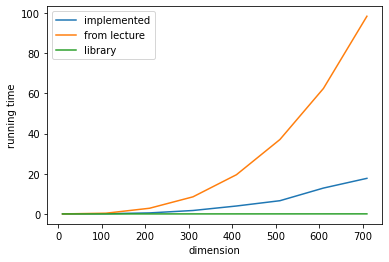

In [101]:
from matplotlib import pyplot as plt
dim_list = [i for i in range(10, 800, 100)]


plt.plot(dim_list, impl_time, label = 'implemented')
plt.plot(dim_list, lecture_time, label = 'from lecture')
plt.plot(dim_list, library_time, label = 'library')
plt.ylabel('running time')
plt.xlabel('dimension')
plt.legend()
plt.show()

As we can see implemented Doolittle Algorithm works better, than naive, but not as good, as library algorithm.

Main idea of speed up computation of LU factorization includes block implementation. Because its easy to multiply and if they fits into cash it speeds up computation very well. So we need divide matrix into blocks, so their size fits into cash and also we could parallelize computations. It could be used for future improvement of Doolittle Algorithm.

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real.


$\square$ $\circ$ As Hermitian matrix is normal then prove that for Hermitian matrix all eigenvalues satisfy are real.


 Take eigenvalue $\lambda$ and corresponding to its eigenvector $\vec{v}\neq 0$.

So $H\vec{v}=\lambda\vec{v}$. Then:

$\lambda <\vec{v}, \vec{v}> = <\lambda \vec{v}, \vec{v}> = <H\vec{v}, \vec{v}> = <\vec{v}, H^{*}\vec{v}> =  <\vec{v}, H\vec{v}> = <\vec{v}, \lambda\vec{v}> = \overline{\lambda}<\vec{v}, \vec{v}>.$

As $\vec{v}\neq 0 \rightarrow <\vec{v}, \vec{v}> \neq 0 \Rightarrow $ divide and get $\lambda = \overline{\lambda}\Rightarrow \lambda$ is real. 

As $\lambda$ is arbitrary eigenvalue, then all eigenvalues of Hermitian matrix are real. That means that normal matrix also should have real eigenvalues to be Hermitian matrix. 



$\circ$ Now prove that each normal matrix with real eigenvalues is Hermitian.

A - normal matrix $\Rightarrow A^{*}A=AA^{*}$. Using spectral decomposition for normal matrix A we could write that $A = VDV^{-1}=VDV^{*}$, where V is unitary matrix and D is diagonal matrix with real eigenvalues. So $D=D^{*}\Rightarrow A^{*} = (VDV^{*})^{*} = VD^{*}V^{*} = VDV^{*}=A\Rightarrow$ A is Hermitian matrix. $ \ \ \ \blacksquare$




* Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 



$\square$


$\circ$ As unitary matrix is normal then we need to prove that for unitary matrix all eigenvalues satisfy $|\lambda| = 1$.


$\begin{equation*}
 \begin{cases}
   Ax=\lambda x \ \ (1) &\\
   x^{*}A^{*}=\lambda x^{*} \ \ (2)
 \end{cases}
\end{equation*}$ 


1) Multiply (1) on $A^{*}$ from left:

$\begin{equation*}
 \begin{cases}
   x=\lambda A^{*}x \ \ (1') &\\
   x^{*}A^{*}=\lambda x^{*} \ \ (2') 
 \end{cases}
\end{equation*}$ 

2) Multiply (1') on $x^{*}$ from left and use (2'):

$\begin{equation*}
 \begin{cases}
   \|x\|^{2}=\lambda \lambda^{*}\|x\|^{2} \ \ (1'')&\\
   x^{*}A^{*}=\lambda x^{*} \ \ (2'')
 \end{cases}
\end{equation*}$ 


3) From (1''): $\ \ \ \mid \lambda \mid = 1 $


$\circ$ Prove that each normal matrix with $|\lambda| = 1$ is unitary.

A - normal matrix $\Rightarrow A^{*}A=AA^{*}$. Using spectral decomposition for normal matrix A we could write that $A = VDV^{-1}=VDV^{*}$, where V is unitary matrix and D is I matrix. So $A=VV^{*}, A^{*}=VV^{*}, AA^{*}=A^{*}A=VV^{*}VV^{*}=I$ $\Rightarrow$ A is unitary matrix. $ \ \ \ \blacksquare$


* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.


$\square \ \ \ 
    J(0) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     0 & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$


Find eigenvalues of $J(\varepsilon)$:

Denote $J^{n}(\varepsilon)$ as nxn matrix $J(\varepsilon).$
 
$det(J^{n}(\varepsilon)-\mu I) = (\lambda-\mu)det(J^{n-1}(0)-\mu I) + (-1)^{n+1}\varepsilon =  (\lambda-\mu)^{n}+(-1)^{n+1}\varepsilon = 0$

 $(\lambda-\mu)^{n} = \pm \varepsilon$
 
 $\mu = \lambda\pm \varepsilon^{\frac{1}{n}}$

So because of perturbation, the mistake is equal to $|\varepsilon^{\frac{1}{n}}|\rightarrow 1$ for $n\rightarrow \infty \  \  \blacksquare$

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [1]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
#     put G in csr format
    if scipy.sparse.issparse(G)==False:
        G = np.array(G, dtype=np.float32)
        G = csr_matrix(G)
    col_sum = np.sum(G, axis=0)
    idx = np.argwhere(col_sum == 0)
    if len(idx):
        for i in idx[:, 1]:
            col_sum[0, i] = 1.0
    col_sum = 1.0 / col_sum
    A = G@diags(np.array(col_sum)[0])
    return A

In [2]:
import scipy
from scipy.sparse import csr_matrix
import numpy as np
from scipy.sparse import diags
from tqdm import tqdm

# str are links to each vertex
G = np.array([
    [0,0,1,0,0], 
    [1,0,1,0,0], 
    [0,1,0,0,0], 
    [0,0,0,0,1], 
    [0,0,0,1,0]  
])

In [3]:
A = pagerank_matrix(G)

In [4]:
print(f"Sparse PageRank matrix: \n", A.toarray())

Sparse PageRank matrix: 
 [[0.  0.  0.5 0.  0. ]
 [1.  0.  0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]


In [5]:
# Check column sum
for i in range(A.toarray().shape[0]):
    assert A.toarray()[:,i].sum()==1, "Sum of column is not equal to 1"

In [6]:
A.toarray()

array([[0. , 0. , 0.5, 0. , 0. ],
       [1. , 0. , 0.5, 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]], dtype=float32)

In [7]:
print('max eigenvalue is', np.linalg.eig(A.toarray())[0].max().real)

print('max multiplicity:', list(np.linalg.eig(A.toarray())[0]).count(1))

max eigenvalue is 1.0
max multiplicity: 2


* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [8]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# # OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    res = np.zeros(num_iter + 1)
    x_k = x0
    for j in tqdm(range(num_iter)):
        res[j] = np.linalg.norm(A.dot(x_k) - x_k * (A.dot(x_k).T.dot(x_k)), 2) #add residuals on each step
        x_k = A.dot(x_k) #calculate matrix by vector product
        x_k_norm = np.linalg.norm(x_k, 2) # calculate the norm
        x_k = x_k / x_k_norm  # normalize the vector
    x = x_k
    l = A.dot(x_k).T.dot(x_k)
    return x, l, res

In [9]:
A = np.array([
    [2, -1],
    [-1, 2]])

x, l, res = power_method(A, np.random.rand(2), 100)
print('max eigenvalue is equal to ', l)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 19915.03it/s]

max eigenvalue is equal to  3.0


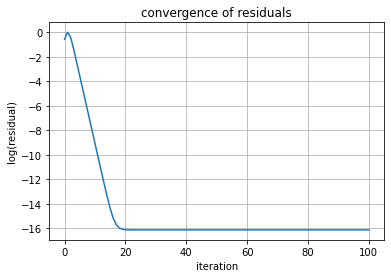

In [10]:
from matplotlib import pyplot as plt

def plot_residual(res):
    plt.title('convergence of residuals')
    plt.plot(np.log(res+1e-7))
    plt.grid()
    plt.xlabel('iteration')
    plt.ylabel('log(residual)')
    plt.show()

res = plot_residual(res)

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33075.50it/s]


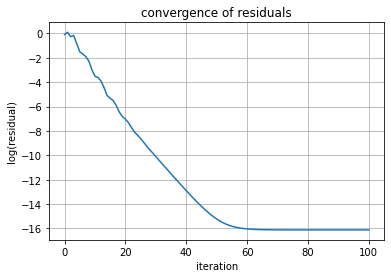

final residual value is:  0.0


In [11]:
G = np.array([
    [0,0,1,0,0], 
    [1,0,1,0,0], 
    [0,1,0,0,0], 
    [0,0,0,0,1], 
    [0,0,0,1,0]  
])

A = pagerank_matrix(G).toarray()

x0 =  5*np.random.rand(A.shape[0])-2
x0 /= np.sqrt(x0@x0)

x, l, res = power_method(G, x0, 100)
plot_residual(res)
print('final residual value is: ', res[-1])

Maybe in some cases it could have problems with convergence because of graph separability. We haven't path from cycle nodes 3 and 4 to another part of the graph.

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33399.46it/s]


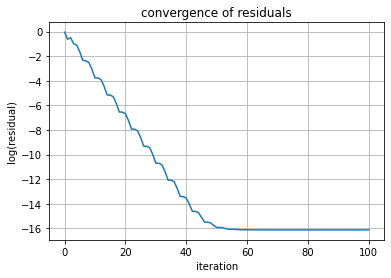

final residual value is:  0.0


In [12]:
# Сonsider the same graph, but with additional self loop at node 4.
G = np.array([
    [0,1,0,0,0],
    [0,0,1,0,0],
    [1,1,0,0,0],
    [0,0,0,0,1],
    [0,0,0,1,1]
])

A = pagerank_matrix(G).toarray()


x0 =  5*np.random.rand(A.shape[0])-2
x0 /= np.sqrt(x0@x0)


x, l, res = power_method(A, x0, 100)
plot_residual(res)
print('final residual value is: ', res[-1])

First two eigenvectors could be the same. In this case power iteration method will give a vector equal to linear combination of corresponding eigenvectors. If the signs are the same, algorithm will converge, otherwise - not converge. This additional loop will change the sign of one of the largest eigenvalues, thats why algorithm converge.

In [13]:
# Launch power method for matrix G several times
for i in range(10): 
    
    x0 =  i*np.random.rand(A.shape[0])-2
    x0 /= np.sqrt(x0@x0)

    x, l, res = power_method(A, i*np.random.rand(5)-1, 100)
    print('{}: eigenvalue:\t {:.4}, eigvector: [{:.4}, {:.4}, {:.4}, {:.4}, {:.4}]'.format(i, l, *x))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 49228.92it/s]

0: eigenvalue:	 1.0, eigvector: [-0.2567, -0.5134, -0.5134, -0.2852, -0.5705]
1: eigenvalue:	 1.0, eigvector: [-0.2172, -0.4343, -0.4343, -0.3393, -0.6786]
2: eigenvalue:	 1.0, eigvector: [0.3243, 0.6486, 0.6486, 0.1034, 0.2068]
3: eigenvalue:	 1.0, eigvector: [0.3326, 0.6652, 0.6652, 0.03003, 0.06007]
4: eigenvalue:	 1.0, eigvector: [-0.2203, -0.4406, -0.4406, -0.3356, -0.6712]
5: eigenvalue:	 1.0, eigvector: [-0.06233, -0.1247, -0.1247, 0.4393, 0.8787]
6: eigenvalue:	 1.0, eigvector: [0.2752, 0.5503, 0.5503, 0.2524, 0.5048]
7: eigenvalue:	 1.0, eigvector: [0.3332, 0.6663, 0.6663, -0.01438, -0.02876]
8: eigenvalue:	 1.0, eigvector: [0.1913, 0.3826, 0.3826, 0.3662, 0.7325]
9: eigenvalue:	 1.0, eigvector: [0.2836, 0.5673, 0.5673, 0.2349, 0.4698]


They depend on initial guesses because the multiplicity of maximal eigenvalue is greater than 1. That mean that dimensionality of subspace, which consists of eigenvectors,  is more then 1

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 25114.09it/s]


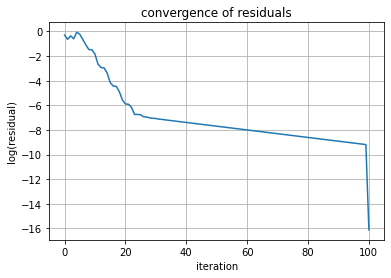

In [14]:
# Create A_d matrix
A = pagerank_matrix(G).toarray()
d = 0.97 #damping factor
A_d = d * A + (1-d) / A.shape[0] * np.ones_like(A)

x0 = 2*np.random.rand(A_d.shape[0])-1
x0 /= np.sqrt(x0@x0)

x, l, res = power_method(A_d, x0, 100)
plot_residual(res)

In [15]:
# The second largest eigenvalue for A_d:
np.sort(np.abs(np.linalg.eigvals(A_d)))[-2]

0.97

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50153.10it/s]


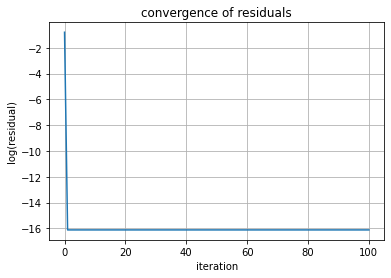

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 49298.35it/s]


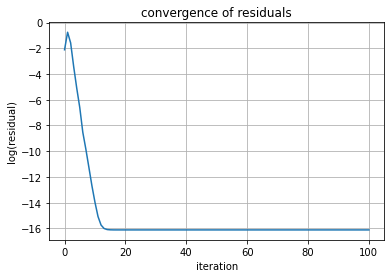

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50147.11it/s]


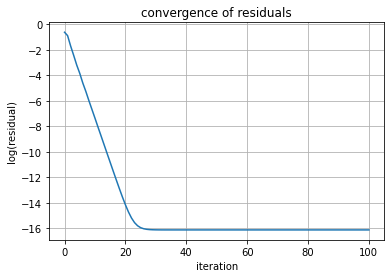

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50766.21it/s]


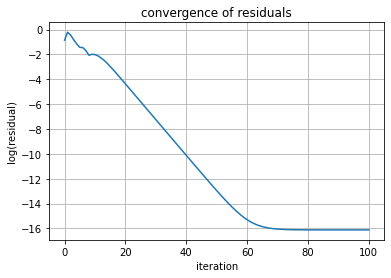

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 33436.73it/s]


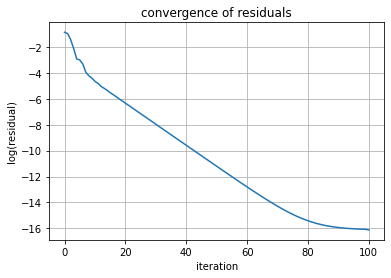

In [16]:
# Changing the value of damping factor, try to get dependence
ds = [0., 0.25, 0.5, 0.75, 0.85]
for d in ds:
    Ad = d*A+ (1-d) / A.shape[0] * np.ones_like(A)
    x_init = 2*np.random.rand(Ad.shape[0])-1
    x_init /=np.sqrt(x_init@x_init)
    x, l, res = power_method(Ad, x_init, 100)
    plot_residual(res)

In [17]:
# The second largest eigenvalue for A_d:
np.sort(np.abs(np.linalg.eigvals(Ad)))[-2]

0.85

Convergence rate is decreases with increasing of damping factor. 

The second maximal eigenvalue is equal to damping factor, as maximal eigenvalue is equal to one.

In [18]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts TODO
    y = d * A@x + (1-d) * np.mean(x)
    return y

In [19]:
from scipy.sparse import csr_matrix
import time

d = 0.9
N = 10000
# create csr matrix
A = np.zeros((N, N))
idx = np.random.randint(0, N, size=(100, 2))
A[idx] = 1.0
A = csr_matrix(A)

x = np.random.uniform(size=N)

matvec_time = %timeit -o -q pagerank_matvec(A, d, x)
direct_time = %timeit -o -q d*A@x + (1-d)/N*np.ones(N)@x


In [20]:
print('Matvec average time:', matvec_time)
print('Direct time average:', direct_time)

Matvec average time: 9.77 ms ± 359 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Direct time average: 11 ms ± 380 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As we could see direct approach is slower.

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [21]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp/dblp_authors.npz', 'dblp/dblp_graph.npz')

In [22]:
print('fraction of nonzero elements ', G.nonzero()[0].shape[0] / (G.shape[0] * G.shape[1]))

fraction of nonzero elements  4.4986518152305776e-05


In [37]:

col_sum = np.squeeze(np.asarray(np.sum(G, axis=0)))
top_authors = sorted(range(len(col_sum)), reverse=True, key=lambda k: col_sum[k])[:10]
print('top 10 authors are: ',authors[top_authors])

top 10 authors are:  ['Hari Balakrishnan' 'Anil K. Jain' 'Chih-Jen Lin' 'Scott Shenker'
 'David G. Lowe' 'Jitendra Malik' 'David E. Goldberg' 'Michael I. Jordan'
 'Vladimir Vapnik' 'Jiawei Han']


In [24]:
from scipy.sparse import diags
import scipy

G[G.nonzero()]  = 1.0

In [25]:
G

<1766547x1766547 sparse matrix of type '<class 'numpy.float64'>'
	with 140388901 stored elements in Compressed Sparse Row format>

In [26]:
A = pagerank_matrix(G)

In [27]:
d = 0.85
cols_sum = np.squeeze(np.asarray(np.sum(A, axis=0)))

epsilon = 1e-10
is_stochastic = 1

for col in range(A.shape[0]):
    if abs(cols_sum[col]) > epsilon and abs(cols_sum[col] - 1) > epsilon:
        is_stochastic = 0
        print(cols_sum[col])
        break
        
if (is_stochastic):
    print("Matrix is stochastic")
else:
    print("Matrix is not stochastic")

Matrix is stochastic


In [28]:
from scipy.sparse import linalg
L = linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))

In [29]:
x0 = np.ones(A.shape[0])
x, l, res = power_method(L, x0, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:50<00:00,  5.31s/it]


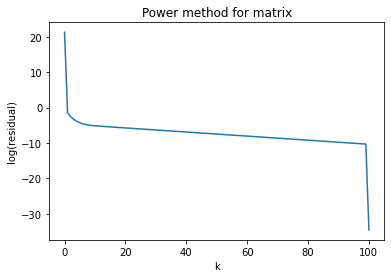

In [32]:
plt.title("Power method for matrix")
plt.ylabel("log(residual)")
plt.xlabel("k")
plt.plot(np.log(res+1e-15))
plt.show()

In [33]:
# Top authors
top_authors2 = sorted(range(len(x)), reverse=True, key=lambda k: x[k])[:10]
print('Top Pagerank authors are: ', authors[top_authors2])

Top Pagerank authors are:  ['Wei Wang' 'Yang Liu' 'Wei Zhang' 'Wei Li' 'Lei Wang'
 'Athanasios V. Vasilakos' 'Lei Zhang' 'Jun Zhang' 'Jun Wang' 'Li Li']


Authors are different to the most cited one, but they  looks similar to list of authors with a lot of references to other works.

In [38]:
col_sum = np.squeeze(np.asarray(np.sum(G, axis=1)))
ref_authors = sorted(range(len(col_sum)), reverse=True, key=lambda k: col_sum[k])[:10]
print('Authors that reference to much other works: ',authors[ref_authors])

Authors that reference to much other works:  ['Wei Wang' 'Yang Liu' 'Wei Zhang' 'Lei Zhang' 'Lei Wang' 'Wei Li'
 'Jun Wang' 'Wei Liu' 'Jun Zhang' 'Yan Zhang']


### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [44]:
from scipy.spatial.distance import chebyshev
def chebyshev_norm(flatten_matrix):
    a = flatten_matrix
    norms = []
    x = a.copy()
    for i in range(a.shape[0]):
        x = np.roll(a, i)
        norms.append(chebyshev(a, x))
    return np.max(norms) 

In [45]:
import scipy.linalg
from tqdm import tqdm
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    A_k = A_init
    convergence = np.zeros(num_iter)
    for k in tqdm(range(num_iter)):
        Q_k, R_k = scipy.linalg.qr(A_k)
        A_k = R_k.dot(Q_k)
        convergence[k] = chebyshev_norm(R_k.flatten())
    return A_k, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [46]:
def create_matrix(diag_broadcast, n):
    m = len(diag_broadcast)
    # check the num of diagonals in matrix
    assert m==3 or m==5
    if (m==3):
    #     get tridiagonal matrix
        diagonals = [[diag_broadcast[0]]*(n-1), [diag_broadcast[1]]*n, [diag_broadcast[2]]*(n-1)]
        A = diags(diagonals, [-1, 0, 1]).toarray()
    else:
    #     get pentidiagonal matrix
        diagonals = [[diag_broadcast[0]]*(n-2), [diag_broadcast[1]]*(n-1), [diag_broadcast[2]]*n, [diag_broadcast[3]]*(n-1), [diag_broadcast[4]]*(n-2)]
        A = diags(diagonals, [-2, -1, 0, 1, 2]).toarray()
    return A

In [47]:
from scipy.sparse import diags
A = create_matrix(diag_broadcast =[-1,2,-1], n=11)

In [48]:
Ak, convergence = qr_algorithm(A, 400)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 96.18it/s]


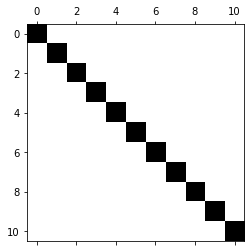

In [49]:
from matplotlib import pyplot as plt
plt.spy(Ak, precision=1e-7)

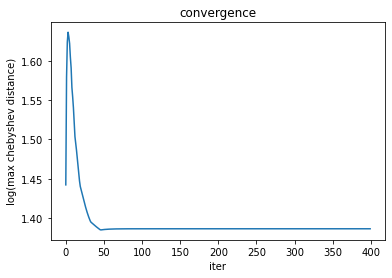

In [50]:
plt.title('convergence')
plt.plot(np.log(convergence))
plt.xlabel('iter')
plt.ylabel('log(max chebyshev distance)')
plt.show()

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 103.34it/s]


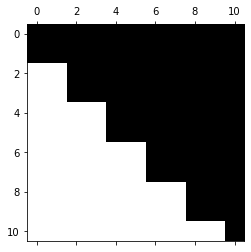

In [51]:
A = create_matrix(diag_broadcast =[5,3,-2], n=11)

Ak, convergence = qr_algorithm(A, 250)

plt.spy(Ak, precision=1e-7)

We get upper triangular matrix

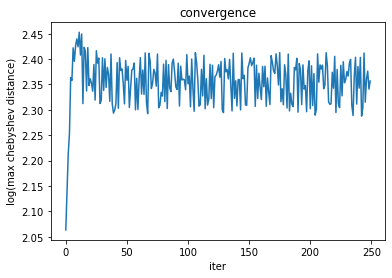

In [52]:
plt.title('convergence')
plt.plot(np.log(convergence))
plt.xlabel('iter')
plt.ylabel('log(max chebyshev distance)')
plt.show()

From this graph we could see that there is no convergence

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redifine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix}
v_1\\
\dots \\
v_n
\end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 

$\square$ Multiply by nonzero vector $v_{1}$: $Av_{1} = VTV^{-1}v_{1}\ \ \  (1)$

$V^{-1}V=VV^{-1}= I$

$V = [v_{1}, v_{2}, v_{3}, \dots, v_{n}]^{T}$

$V^{-1}v_{1}$ is a first column of matrix $I$ $\Rightarrow$ $V^{-1}v_{1} = [1, 0, 0,\dots 0]^{T}$.

Then $TV^{-1}v_{1}$ is the first column of matrix T.

As T is almost upper triangular, $TV^{-1}v_{1} = [T_{11}, T_{21}, 0, 0,\dots, 0]^{T}$

If we assume that $T_{21}=0 \Rightarrow TV^{-1}v_{1} = [T_{11}, 0, 0, 0,\dots,0]^{T}$.


Then $VTV^{-1}v_{1}$ is equal to $v_{1}T_{11}, $where $T_{11}$ is scalar.

SO we get, $Av_{1} = v_{1}T_{11}$. As $v_{1}$ is not an eigenvector of A $\Rightarrow$ $T_{21}\neq 0. \ \ \ \blacksquare$

- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


$\square $ Find eigenvalues of matrix A.

$|A-\lambda I| = (3-\lambda)^{2}-1=0 \Rightarrow \lambda_{1,2} = 2,4$ and eigenvectors are equal to $[a,a]^{T}$ and $[a,-a]^{T}.$

Assume A is J-decomposable. Then $v_{1}$ is eigenvector of A $\Rightarrow$ from previous task $T_{21}=0\Rightarrow$   $T = \begin{bmatrix}
T_{11}\   \ T_{12}\\
0\   \ \ \ \  T_{22}\\
\end{bmatrix}$

As $T_{11}$ is equal to first eigenvalue(from previous task), for example $T_{11}=2\Rightarrow A  = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix} = \frac{1}{ay-ax} \begin{bmatrix}
a\   \ x\\
a\   \ y\\
\end{bmatrix} \begin{bmatrix}
2\   \ T_{12}\\
0\   \ T_{22}\\
\end{bmatrix}\begin{bmatrix}
\ \ \ \ y\   \ -x\\
-a\   \ \ \ a\\
\end{bmatrix}$ (*)

Find x and y from J-orthonormality for matrix V:

$a^{2}- x^{2}=\pm 1, \ \  a^{2} - y^{2}=\pm 1, \ \  a^{2}-xy = 0 $.

From first two equations it follows that either $x=y$, or $x=-y$. First case is not good, because V will be singular matrix, so $x=-y$.  So we get $a^{2}-y^{2}=\pm 1$ and $a^{2}+y^{2}=0 $. As a is real and $y^{2}=a^{2}\pm 1$ then from second equation:

$2a^{2}\pm 1 = 0$, which doesn't hold for sign $'+'\Rightarrow A$ is not J-decomposable. Same situation for another eigenvector and eigenvalue. 

If we open brackets in (*), we could get,  that  $T_{12}=0, T_{22}=4$. That means that matrix A is diagonazible, and T = diag(2, 4). But it leads to orthogonality of matrices from left and right side of T. So [x, y] is the second eigenvector correspond to second eigen value $\Rightarrow$ obtained orthonormal matrix is not J-orthonormal$\Rightarrow$ A is not J-decomposable.
$\ \ \ \blacksquare$


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.  

TODO


## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [53]:
import numpy as np
from matplotlib import pyplot as plt
# define num of points
N = 5000
x = np.linspace(0, 1, N)
xx, yy = np.meshgrid(x, x)
# define function
def f(x, y):
    return np.exp(-np.sqrt(x**2+y**2))

A = f(xx, yy) 

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


In [59]:
# Your solution is here
def generate_samples(M, r):
#     generate matrixes with random indixes
    idx_array =  [i for i in range(N)]
    random_row_idx = np.random.choice(idx_array, r, replace=False)
    random_column_idx = random_row_idx #np.random.choice(idx_array, r, replace=False)
    A_L = A[random_row_idx, :]
    A_LJ = A_L[:, random_column_idx]
    A_J = A[:, random_column_idx]
    return A_L, A_LJ, A_J

def compute_error(A_r, A):
    error = np.linalg.norm(A-A_r, ord='fro')/np.linalg.norm(A, ord='fro')
    return error

In [60]:
from tqdm import tqdm
r = 5
errors = []
det_values = [] #values of determinant
M = 500
for i in tqdm(range(M)):
    A_L, A_LJ, A_J = generate_samples(M, r)
    det = np.linalg.det(A_LJ)
    det_values.append(det)
#     check singularity
    if det == 0:
        continue #not include this sample
    rank_values.append(rank)
    A_r = A_J @ np.linalg.inv(A_LJ) @ A_L
    errors.append(compute_error(A_r, A))


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:58<00:00,  4.24it/s]


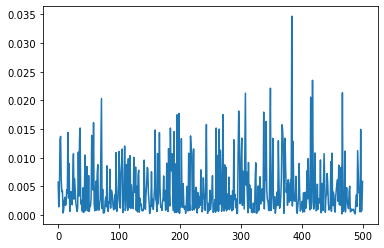

In [61]:
plt.plot(errors)

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

1. Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

2. Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

3. **If $|b_{ij}| > 1 + \delta$, then**:

    Swap rows $i$ and $j$ in $B$. By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 2__.

    **elseif $|b_{ij}| < 1 + \delta$**:
    
    return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 2 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [92]:
def reorder_rows(matrix, idx1, idx2):
    matrix[idx1, :], matrix[idx2, :] = matrix[idx2, :].copy(), matrix[idx1, :].copy()
    return matrix

r = 550
n = 1000
delta = 0.01
delta_ = 1 + delta

# create random matrix A
A = np.random.rand(n, r)

def dominant_submatrix_search(A):
    n, r = A.shape[0], A.shape[1]
    max_num_steps = 10000
    idx_array =  [i for i in range(n)]
    for step in range(max_num_steps):
        random_row_idx = np.random.choice(idx_array, r, replace=False)
        not_choosen_idx = [i for i in idx_array if i not in random_row_idx]
        # reorder rows in A
        A_ = np.concatenate((A[random_row_idx, :],A[not_choosen_idx , :] ), axis=0)
        A_dom = A[random_row_idx, :]
        flag = True
        while flag:
            B = A_ @ np.linalg.inv(A_dom) #change to efficient approach
            b_ij = np.max(np.abs(B))
            ij = np.unravel_index(np.argmax(np.abs(B)), B.shape)
            if b_ij > delta_:
                B = reorder_rows(B, ij[0], ij[1])
                A_ = reorder_rows(A_, ij[0], ij[1])
                A_dom = A_[:r, :]
            else: 
                flag = False
                return A_dom


In [93]:
# check the convergence of your implementation on random data
A_dom = dominant_submatrix_search(np.random.rand(1000, 500))

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [ ]:
def skeleton(A, r):
    # Your code is here
    n, r = A.shape[0], A.shape[1]
    max_num_steps = 10000
    idx_array =  [i for i in range(n)]
    col_idx = np.random.choice(idx_array, r, replace=False)
    A_dom_cols = A[:, col_idx]
#     we could first find best cols and then  for them find best rows, so we could get approximation matrix.
    for i in range(10):
        A_dom_cols = dominant_submatrix_search(A.T)
        A_dom_rows_of_cols = dominant_submatrix_search(A_dom_cols.T)
#     A_dom_rows_of_cols rxr matrix approximation of matrix A
#    compare them by norm and try to minimize it by more steps of descriebd approach
# TODO
        
    
    
    
    return row_indices, column_indices

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [107]:
# Your solution is here
